# Import Module & Dataset

In [1]:
# Data manipulation and Kaggle integration
import pandas as pd
import nltk
nltk.download('punkt')

# Machine learning and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Natural language processing (NLP)
from sklearn.preprocessing import LabelEncoder

# Deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Export Model
import pickle

# in kaagle
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Make it Pandas Data Frame
df = pd.read_csv("/kaggle/input/youtube-natgeo-dictator-dilema-v3-1/youtube_comments_natgeo_dictator-dilema_v3.1.csv")
df.info()
df.head()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12625 entries, 0 to 12624
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text_akhir  12625 non-null  object
 1   label       12625 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 197.4+ KB


,text_akhir,label
0,highest leader ruins lives people,-1
1,bern switzerland must terrible place consideri...,-1
2,th largest military yes okay sure,1
3,kim yo jong beautiful cow warehouse,1
4,crazy way clap kim,-1


# Preprocessing

In [3]:
print(df['label'].value_counts())
print(df['text_akhir'].isnull().sum())
df = df.dropna()
print(df['text_akhir'].isnull().sum())

label
 1    5003
-1    4055
 0    3567
Name: count, dtype: int64
0
0


In [4]:
# # Tambahkan kolom panjang kata
# df['word_count'] = df['text_akhir'].apply(lambda x: len(str(x).split()))

# # Buang jika terlalu pendek (<3 kata)
# df = df[df['word_count'] >= 3]

In [5]:
print(df.shape)
df.sample(10)

(12625, 3)


,text1,text_akhir,label
4885,kim jung un learn very fast from the us using ...,kim jung un learn fast us using violence terro...,-1
3778,quite scary they are long to keep the regime a...,quite scary long keep regime secret think safe...,-1
8779,north korea proves how much you can brainwash ...,north korea proves much brainwash people train...,1
1374,poor horses bring great fat leaders,poor horses bring great fat leaders,1
3384,imagine what would happen to you and your line...,imagine would happen lineage clapping,0
9573,they added letters more than they needed at th...,added letters needed end title,0
6048,if kim jong un allowed us and european multina...,kim jong un allowed us european multinational ...,1
753,i think there is no evidence that can prove th...,think evidence prove tunnel connected china ac...,0
651,he can t even more handsome and fit his hair l...,even handsome fit hair looks like mutated animals,1
7057,this bird is dangerous imagine he is your girl...,bird dangerous imagine girlfriend suspects mess,-1


# Modelling

- Pelatihan: LSTM
- Ekstraksi Fitur: Tokenization dan Padding
- Pembagian Data: 80/20

In [4]:
# --- Library ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# --- Load Data ---
texts = df['text_akhir'].astype(str).tolist()
labels = df['label'].tolist()

# --- Tokenization & Padding ---
max_vocab = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_vocab, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=max_len)

# --- Label Encoding ---
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(labels)           # dari -1,0,1 → 0,1,2
y = to_categorical(y_encoded, num_classes=3)        # one-hot encoding

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- Buat Model dengan Param Terbaik ---
model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=128),   # embedding_dim = 128
    LSTM(128, return_sequences=False),                # lstm_units = 128
    Dropout(0.3),                                     # dropout_rate = 0.3
    Dense(64, activation='relu'),                     # dense_units = 64
    Dropout(0.3),
    Dense(3, activation='softmax')                    # 3 kelas output
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- Train Model ---
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# --- Evaluasi Akurasi ---
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_labels = train_preds.argmax(axis=1)
test_labels = test_preds.argmax(axis=1)

true_train = y_train.argmax(axis=1)
true_test = y_test.argmax(axis=1)

train_acc = accuracy_score(true_train, train_labels)
test_acc = accuracy_score(true_test, test_labels)

print(f"\n✅ Akurasi Training Set: {train_acc:.2f}")
print(f"✅ Akurasi Testing Set : {test_acc:.2f}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5212 - loss: 0.9636 - val_accuracy: 0.8297 - val_loss: 0.4478
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8949 - loss: 0.3162 - val_accuracy: 0.8614 - val_loss: 0.3887
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9623 - loss: 0.1304 - val_accuracy: 0.8485 - val_loss: 0.4693
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9743 - loss: 0.0917 - val_accuracy: 0.8594 - val_loss: 0.5353
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9789 - loss: 0.0763 - val_accuracy: 0.8465 - val_loss: 0.5956
Epoch 6/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9817 - loss: 0.0579 - val_accuracy: 0.8505 - val_loss: 0.7372
Epoch 7/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9827 - loss: 0.0542 - val_accuracy: 0.8436 - val_loss: 0.6925
Epoch 8/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9882 - loss: 0.0357 - val_accuracy: 0

# Visualisasi 

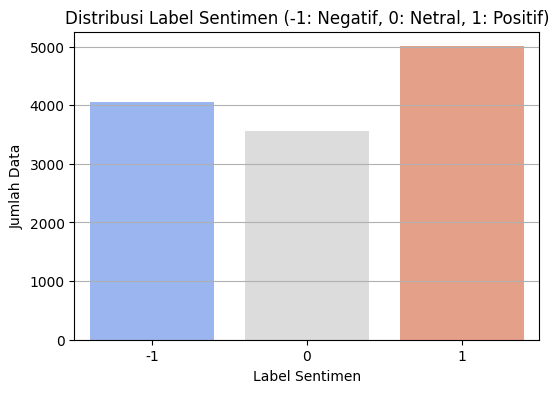

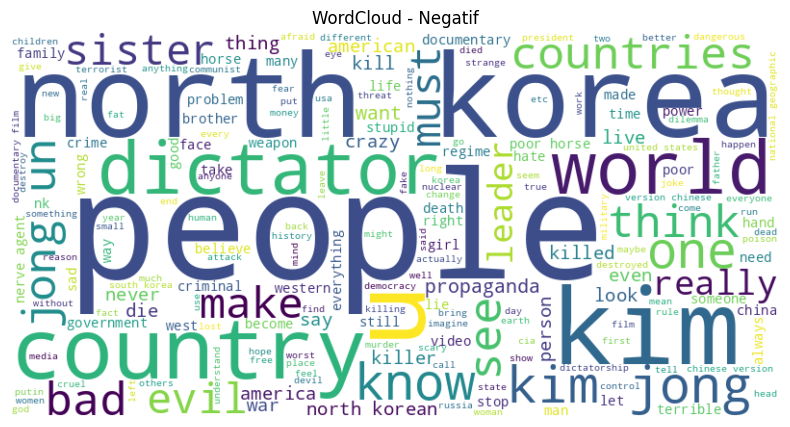

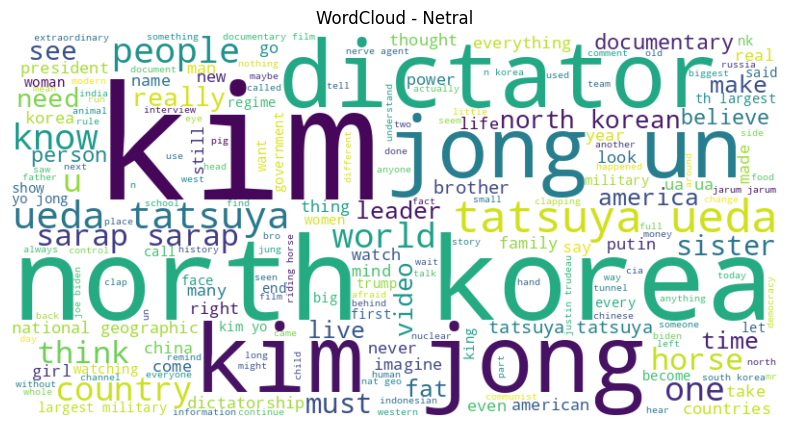

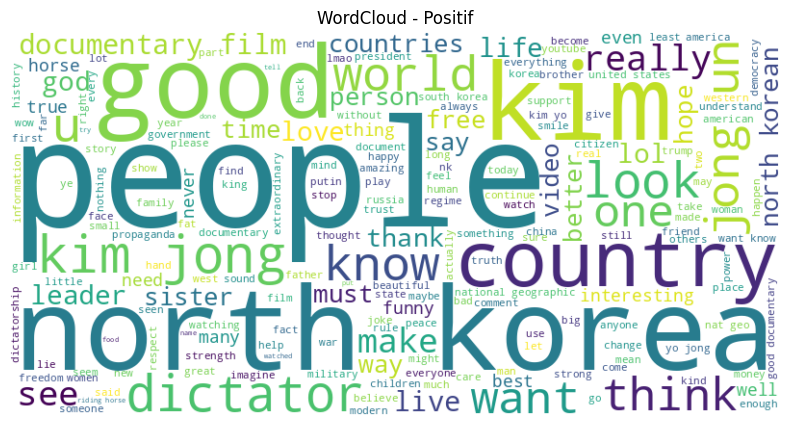

In [5]:
# --- Bar Chart ---
# Pastikan label berupa angka -1, 0, 1
label_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='coolwarm')
plt.xlabel('Label Sentimen')
plt.ylabel('Jumlah Data')
plt.title('Distribusi Label Sentimen (-1: Negatif, 0: Netral, 1: Positif)')
plt.grid(axis='y')
plt.show()

# --- Word Cloud ---
# Fungsi untuk buat wordcloud dari subset data
def generate_wordcloud(data, label_val, label_name):
    text = ' '.join(data[data['label'] == label_val]['text_akhir'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud - {label_name}')
    plt.show()

# Buat wordcloud untuk tiap label
generate_wordcloud(df, -1, 'Negatif')
generate_wordcloud(df,  0, 'Netral')
generate_wordcloud(df,  1, 'Positif')

# Cell Inference

In [8]:
import numpy as np

# Fungsi prediksi
def predict_sentiment_lstm(text, model, tokenizer, encoder, max_len=100):
    # Preprocessing input
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_len)
    
    # Prediksi
    pred = model.predict(padded)
    label_idx = np.argmax(pred)
    label = encoder.inverse_transform([label_idx])[0]
    
    return label, pred[0]

# Contoh penggunaan
sample_texts = [
    "best leader",
    "he is bad leader",
    "meh. nothing special"
]

for text in sample_texts:
    label, probs = predict_sentiment_lstm(text, model, tokenizer, encoder)
    print(f"📝 Input: {text}")
    print(f"🔍 Label: {label} (Probabilities: {probs})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
📝 Input: best leader
🔍 Label: 1 (Probabilities: [1.1815731e-08 2.8698400e-07 9.9999964e-01])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
📝 Input: he is bad leader
🔍 Label: -1 (Probabilities: [9.9966812e-01 2.9409686e-04 3.7783913e-05])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
📝 Input: meh. nothing special
🔍 Label: 0 (Probabilities: [0.24232136 0.58499914 0.1726795 ])

